In [40]:
#import the libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2



In [48]:
# Load cleaned dataset
import pandas as pd

df = pd.read_csv("cleaned_dataset.csv", encoding="latin-1")
df = df.rename(columns={'cleaned_text':'text'})

# Ensure all text entries are strings
df['text'] = df['text'].astype(str)

# Remove empty messages
df = df[df['text'].str.strip() != ""].reset_index(drop=True)



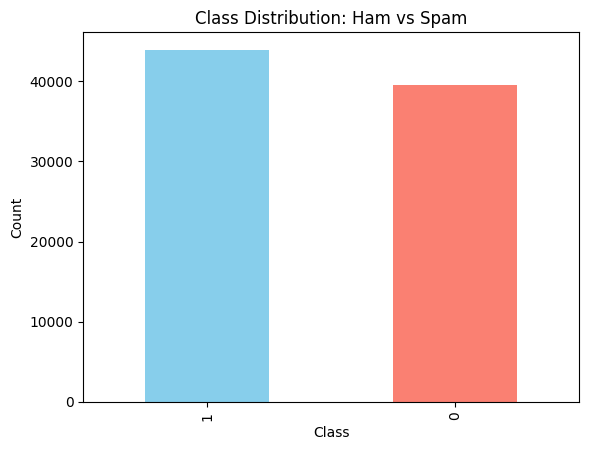

In [42]:
# Class Distribution

df['label'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Class Distribution: Ham vs Spam")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


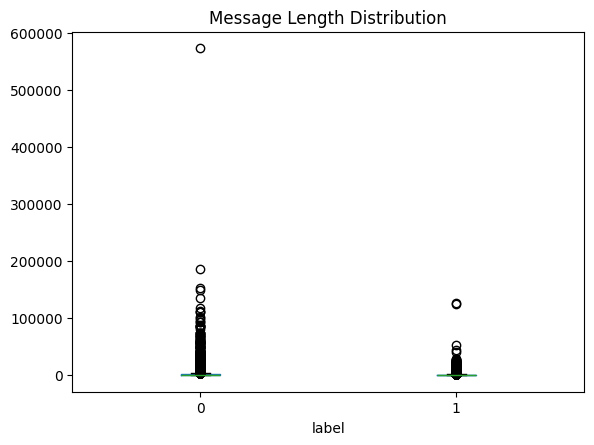

In [49]:
 #Text Length Analysis

df['text_length'] = df['text'].apply(len)
df.boxplot(column='text_length', by='label', grid=False)
plt.title("Message Length Distribution")
plt.suptitle("")
plt.show()


In [60]:
#Word frequency counters
from collections import Counter
spam_words = Counter()
ham_words = Counter()

for msg in df[df['label']==1]['text']:
    spam_words.update(clean_text(msg))

for msg in df[df['label']==0]['text']:
    ham_words.update(clean_text(msg))

print("Top 10 spam words:", spam_words.most_common(10))
print("Top 10 ham words:", ham_words.most_common(10))

Top 10 spam words: [('escapenumber', 338986), ('escapelong', 188159), ('com', 29037), ('http', 27776), ('per', 26146), ('pills', 23128), ('escapenumbermg', 20541), ('price', 18724), ('company', 16590), ('one', 15956)]
Top 10 ham words: [('escapenumber', 809065), ('http', 54459), ('enron', 52858), ('org', 42566), ('com', 40781), ('escapelong', 39137), ('ect', 34743), ('help', 32664), ('samba', 30769), ('list', 28286)]


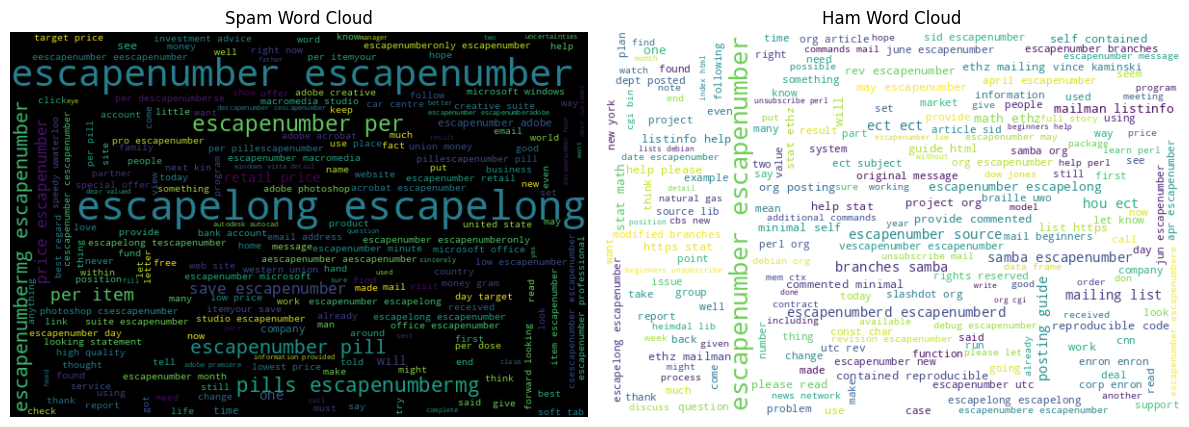

In [51]:
#word clouds
def get_wordcloud_text(messages):
    return " ".join(messages)

spam_text = get_wordcloud_text(df[df['label']==1]['text'])
ham_text = get_wordcloud_text(df[df['label']==0]['text'])

plt.figure(figsize=(12,5))
if spam_text:
    spam_wc = WordCloud(width=600, height=400, background_color='black').generate(spam_text)
    plt.subplot(1,2,1)
    plt.imshow(spam_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Spam Word Cloud")

if ham_text:
    ham_wc = WordCloud(width=600, height=400, background_color='white').generate(ham_text)
    plt.subplot(1,2,2)
    plt.imshow(ham_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Ham Word Cloud")
plt.tight_layout()
plt.show()



In [52]:
#Pattern Analysis (Digits, Upper, Special)
# ===============================
df['num_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_upper'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['num_special'] = df['text'].apply(lambda x: sum(c in string.punctuation for c in x))

print("Digit, Uppercase & Special char usage:\n",
      df.groupby('label')[['num_digits','num_upper','num_special']].mean())


Digit, Uppercase & Special char usage:
        num_digits  num_upper  num_special
label                                    
0             0.0        0.0          0.0
1             0.0        0.0          0.0


In [55]:
#Chi-Square Feature Importance
y = df['label']

vectorizer = CountVectorizer(stop_words='english', token_pattern=r"(?u)\b\w+\b")
X = vectorizer.fit_transform(df['text'])

chi2score, pval = chi2(X, y)
chi2_df = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'chi2_score': chi2score,
    'p_value': pval
}).sort_values(by='chi2_score', ascending=False)

print("Top 20 words associated with spam:\n", chi2_df.head(20))

Top 20 words associated with spam:
                feature     chi2_score  p_value
75288     escapenumber  245559.754951      0.0
75287       escapelong   82939.719451      0.0
72965            enron   58693.556806      0.0
171726             org   44157.771233      0.0
67866              ect   38510.195088      0.0
209314           samba   34115.400652      0.0
105430            help   25540.621995      0.0
225270            stat   23471.135232      0.0
222196          source   23211.174708      0.0
79763             ethz   22759.057868      0.0
138568            list   21090.256940      0.0
185381         posting   20680.674077      0.0
181594           pills   20374.085595      0.0
53502             data   19819.268076      0.0
28653         branches   19258.507723      0.0
101469           guide   18918.992422      0.0
77357   escapenumbermg   18065.084942      0.0
109277             hou   17817.846275      0.0
42278             code   16588.141252      0.0
179072            perl  

In [57]:
#Feature Engineering (TF-IDF + Custom Features)

if df['text'].str.strip().any():
    tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
    X_tfidf = tfidf.fit_transform(df['text'])

    extra_features = df[['text_length','num_digits','num_upper','num_special']].reset_index(drop=True)
    X_features = pd.concat([pd.DataFrame(X_tfidf.toarray()), extra_features], axis=1)

    final_df = pd.concat([df['label'].reset_index(drop=True), X_features], axis=1)
    final_df.to_csv("engineered_spam_dataset.csv", index=False)
    print("Final engineered dataset saved as 'engineered_spam_dataset.csv'")
else:
    print("No valid text to create TF-IDF features.")

Final engineered dataset saved as 'engineered_spam_dataset.csv'
